
## **Oversampling approach for Rhetorical role classification task**. **We name our approach as "$M_{SSO-Mid}$" and "$M_{SSO-End}$".**




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import re
import csv
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam


In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 27.0 MB/s eta 0:00:00


In [6]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [7]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("law-ai/InLegalBERT")
bert_model = AutoModel.from_pretrained("law-ai/InLegalBERT",output_hidden_states=True)
bert_model = bert_model.to('cuda')

# from transformers import AutoTokenizer, AutoModel
# tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
# bert_model = AutoModel.from_pretrained("nlpaueb/legal-bert-base-uncased")
# bert_model = bert_model.to('cuda')

Some weights of the model checkpoint at law-ai/InLegalBERT were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
def numpyarray(sent):
  granola_ids = tokenizer.encode(sent, max_length=100)
  granola_ids = torch.LongTensor(granola_ids)
  granola_ids = granola_ids.to(device)
  # print(granola_ids.shape)
  bert_model.eval()
  granola_ids = granola_ids.unsqueeze(0)
  # print(granola_ids.shape)
  with torch.no_grad():
    out = bert_model(input_ids=granola_ids)
    # print(out[0].shape)
  hidden_states = out[2]
  sentence_embedding = torch.mean(hidden_states[-1], dim=1).squeeze()
  # print(sentence_embedding.shape)
  np_tensor = sentence_embedding.cpu().numpy()
  return np_tensor


In [9]:
f = open("/content/drive/My Drive/Colab Notebooks/LegalEval/RR_train.json")

data = json.load(f)
print("Total training samples provided by the organizers: ", len(data))

AllText=[]
for i in range(len(data)):
    TempText=[]
    if len(data[i]['annotations'][0]['result'])!=0:

        for j in range(len(data[i]['annotations'][0]['result'])):
            TempText.append(data[i]['annotations'][0]['result'][j]['value']['text'])
        AllText.append(TempText)


CleanedText=[]
for i in range(len(AllText)):
    TempCleanedText=[]
    for j in range(len(AllText[i])):
        AllText[i][j]=AllText[i][j].replace("\n"," ")
        AllText[i][j]=re.sub('\s+',' ',AllText[i][j])
        AllText[i][j]=AllText[i][j].lower()
        TempCleanedText.append(AllText[i][j])
    CleanedText.append(TempCleanedText)  
print("After cleaning, total number of samples in training data (documentwise): ", len(CleanedText))

AllLabels=[]
for i in range(len(data)):
    TempLabels=[]
    if len(data[i]['annotations'][0]['result'])!=0:
        for j in range(len(data[i]['annotations'][0]['result'])):
            TempLabels.append(data[i]['annotations'][0]['result'][j]['value']['labels'][0])
        AllLabels.append(TempLabels)
    
for i in range(len(AllLabels)):
    for j in range(len(AllLabels[i])):
        AllLabels[i][j]=AllLabels[i][j].lower()    
print(len(AllLabels)) 

Total training samples provided by the organizers:  247
After cleaning, total number of samples in training data (documentwise):  245
245


In [ ]:
import numpy as np #considers 4 previous sentences, in total 5 sentences
def dataset_creation(doc,labels):
  s1 = np.zeros(768)
  # print(type(s1))
  s2=np.zeros(768)
  s3=np.zeros(768)
  s4=np.zeros(768)
  fl=[]
  fl_l=[]
  dc=[]
  label_list=[]
  dc.append(s1)
  label_list.append('pad')
  dc.append(s2)
  label_list.append('pad')
  dc.append(s3)
  label_list.append('pad')
  dc.append(s4)
  label_list.append('pad')
  dc.append(numpyarray(doc[0]))
  label_list.append(labels[0])
  fl.append(np.stack(dc))
  fl_l.append(label_list)
  dc=[]
  label_list=[]
  dc.append(s2)
  label_list.append('pad')
  dc.append(s3)
  label_list.append('pad')
  dc.append(s4)
  label_list.append('pad')
  dc.append(numpyarray(doc[0]))
  label_list.append(labels[0])
  dc.append(numpyarray(doc[1]))
  label_list.append(labels[1])
  fl.append(np.stack(dc))
  fl_l.append(label_list)
  dc=[]
  label_list=[]
  dc.append(s3)
  label_list.append('pad')
  dc.append(s4)
  label_list.append('pad')
  dc.append(numpyarray(doc[0]))
  label_list.append(labels[0])
  dc.append(numpyarray(doc[1]))
  label_list.append(labels[1])
  dc.append(numpyarray(doc[2]))
  label_list.append(labels[2])
  fl.append(np.stack(dc))
  fl_l.append(label_list)
  dc=[]
  label_list=[]
  dc.append(s4)
  label_list.append('pad')
  dc.append(numpyarray(doc[0]))
  label_list.append(labels[0])
  dc.append(numpyarray(doc[1]))
  label_list.append(labels[1])
  dc.append(numpyarray(doc[2]))
  label_list.append(labels[2])
  dc.append(numpyarray(doc[3]))
  label_list.append(labels[3])
  fl.append(np.stack(dc))
  fl_l.append(label_list)

  for i in range(4,len(doc)):
    dc=[]
    label_list=[]
    dc.append(numpyarray(doc[i-4]))
    label_list.append(labels[i-4])
    dc.append(numpyarray(doc[i-3]))
    label_list.append(labels[i-3])
    dc.append(numpyarray(doc[i-2]))
    label_list.append(labels[i-2])
    dc.append(numpyarray(doc[i-1]))
    label_list.append(labels[i-1])
    dc.append(numpyarray(doc[i]))
    label_list.append(labels[i])
    fl.append(np.stack(dc))
    fl_l.append(label_list)
  # for i in range(len(fl)):
  #   print(fl[i].shape)
  fl=np.stack(fl)
  return fl, fl_l

In [ ]:
samplesX=[]
samplesY=[]
for i in range(len(CleanedText)):
  x,y=new_dataset_creation(CleanedText[i],AllLabels[i])
  samplesX.append(x)
  samplesY+=y
  print(i)
samplesX=np.vstack(samplesX)
print(len(samplesY))
print(samplesX.shape)

In [ ]:
np.save('/content/drive/My Drive/Colab Notebooks/LegalEval/SamplesX_5_sent.npy',samplesX)
with open("/content/drive/My Drive/Colab Notebooks/LegalEval/SamplesY_5_sent.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(samplesY)

In [10]:
f = open("/content/drive/My Drive/Colab Notebooks/LegalEval/RR_dev.json")

data = json.load(f)
print("Total validation samples provided by the organizers: ", len(data))

AllText=[]
for i in range(len(data)):
    TempText=[]
    if len(data[i]['annotations'][0]['result'])!=0:

        for j in range(len(data[i]['annotations'][0]['result'])):
            TempText.append(data[i]['annotations'][0]['result'][j]['value']['text'])
        AllText.append(TempText)


CleanedText=[]
for i in range(len(AllText)):
    TempCleanedText=[]
    for j in range(len(AllText[i])):
        AllText[i][j]=AllText[i][j].replace("\n"," ")
        AllText[i][j]=re.sub('\s+',' ',AllText[i][j])
        AllText[i][j]=AllText[i][j].lower()
        TempCleanedText.append(AllText[i][j])
    CleanedText.append(TempCleanedText)  
print("After cleaning, total number of samples in validation data (documentwise): ", len(CleanedText))

AllLabels=[]
for i in range(len(data)):
    TempLabels=[]
    if len(data[i]['annotations'][0]['result'])!=0:
        for j in range(len(data[i]['annotations'][0]['result'])):
            TempLabels.append(data[i]['annotations'][0]['result'][j]['value']['labels'][0])
        AllLabels.append(TempLabels)
    
for i in range(len(AllLabels)):
    for j in range(len(AllLabels[i])):
        AllLabels[i][j]=AllLabels[i][j].lower()    
print("After cleaning, total number of labels in validation data (documentwise): ", len(AllLabels)) 

Total validation samples provided by the organizers:  30
After cleaning, total number of samples in validation data (documentwise):  30
After cleaning, total number of labels in validation data (documentwise):  30


In [11]:
npy_samplesX=np.load('/content/drive/My Drive/Colab Notebooks/LegalEval/samplesX_5_sent.npy')
print(npy_samplesX.shape)
npy_ValSamplesX=np.load('/content/drive/My Drive/Colab Notebooks/LegalEval/ValSamplesX_5_sent.npy')
print(npy_ValSamplesX.shape)


df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/LegalEval/samplesY_5_sent.csv',header=None)
df_samplesY=df.values.tolist()
print(len(df_samplesY))
print(df_samplesY[0])
print(df_samplesY[5])

df_val=pd.read_csv('/content/drive/My Drive/Colab Notebooks/LegalEval/ValSamplesY_5_sent.csv',header=None)
df_val.describe()
df_val_samplesY=df_val.values.tolist()
print(len(df_val_samplesY))
print(df_val_samplesY[0])
print(df_val_samplesY[5])

(28986, 5, 768)
(2879, 5, 768)
28986
['pad', 'pad', 'pad', 'pad', 'preamble']
['preamble', 'preamble', 'preamble', 'none', 'fac']
2879
['pad', 'pad', 'pad', 'pad', 'preamble']
['preamble', 'preamble', 'preamble', 'preamble', 'preamble']


**This is our oversampling approach:**

---
1. Firstly, we decide to keep only one copy of any 5-sentence sample where at least one of the labels is a dummy label for a 0-vector sentence ($s_{0}$). 

2. Secondly, for all the other types of samples, we utilize the normalized frequencies of each class to calculate the exact number of times we will oversample them.

In [1]:
import math
freq_dict={0:10695, 1:1315, 2:698, 3:5744,4:367, 5:1423, 6:158,7:1431, 8:4167, 9:674, 10:752, 11:1081, 12:481}
noOversamples=[]
for i in range(len(encoded_samplesY)):
  if 13 in encoded_samplesY[i]:
    noOversamples.append(1)
  else:
    NormalizeFreq=[]
    for j in range(len(encoded_samplesY[i])):
      NormalizeFreq.append(freq_dict[encoded_samplesY[i][j]]/freq_dict[0])
    noOversamples.append(math.ceil(5/sum(NormalizeFreq))) #normalized frequency

print(len(noOversamples))
print(noOversamples)

In [ ]:
overSampleX=[]
overSampleY=[]
for i in range(len(noOversamples)):
  for j in range(noOversamples[i]):
    
    overSampleX.append(npy_samplesX[i])
    overSampleY.append(encoded_samplesY[i])

overSampleX=np.stack(overSampleX)
overSampleY=np.stack(overSampleY)

print(overSampleX.shape)
print(overSampleY.shape)

**We have created the samples using oversampling approach and saved in a .npy format that we load to utilize further during the training process.**

In [12]:
xtr=np.load('/content/drive/My Drive/Colab Notebooks/LegalEval/overSampleSent5Hyp5X.npy')
ytr=np.load('/content/drive/My Drive/Colab Notebooks/LegalEval/overSampleSent5Hyp5Y.npy')

In [13]:
xval=np.load('/content/drive/My Drive/Colab Notebooks/LegalEval/Val_overSampleSent5Hyp5X.npy')
yval=np.load('/content/drive/My Drive/Colab Notebooks/LegalEval/Val_overSampleSent5Hyp5Y.npy')

In [14]:
print(xtr.shape)
print(ytr.shape)
print(xval.shape)
print(yval.shape)

(104825, 5, 768)
(104825, 5)
(9648, 5, 768)
(9648, 5)


In [15]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from keras.optimizers import Adam
from tensorflow.keras import regularizers 
 
model = Sequential()
model.add(InputLayer(input_shape=(5,768, )))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(14)))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(0.001),metrics=['accuracy'])
 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 256)           918528    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 5, 256)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 5, 256)           394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 5, 256)            0         
                                                                 
 time_distributed (TimeDistr  (None, 5, 14)            3598      
 ibuted)                                                         
                                                        

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history=model.fit(xtr, ytr, validation_data=(xval,yval),epochs =500,callbacks=[es], batch_size= 16, shuffle=True)

Epoch 1/500
6552/6552 [==============================] - 76s 9ms/step - loss: 0.5489 - accuracy: 0.8085 - val_loss: 1.6936 - val_accuracy: 0.6402
Epoch 2/500
6552/6552 [==============================] - 63s 10ms/step - loss: 0.1942 - accuracy: 0.9330 - val_loss: 2.0352 - val_accuracy: 0.6504
Epoch 3/500
6552/6552 [==============================] - 57s 9ms/step - loss: 0.1104 - accuracy: 0.9623 - val_loss: 2.3360 - val_accuracy: 0.6418
Epoch 4/500
6552/6552 [==============================] - 57s 9ms/step - loss: 0.0755 - accuracy: 0.9743 - val_loss: 2.4033 - val_accuracy: 0.6415
Epoch 5/500
6552/6552 [==============================] - 74s 11ms/step - loss: 0.0596 - accuracy: 0.9800 - val_loss: 2.6955 - val_accuracy: 0.6358
Epoch 6/500
6552/6552 [==============================] - 64s 10ms/step - loss: 0.0504 - accuracy: 0.9830 - val_loss: 2.9728 - val_accuracy: 0.6250
Epoch 7/500
6552/6552 [==============================] - 61s 9ms/step - loss: 0.0440 - accuracy: 0.9853 - val_loss: 2.975

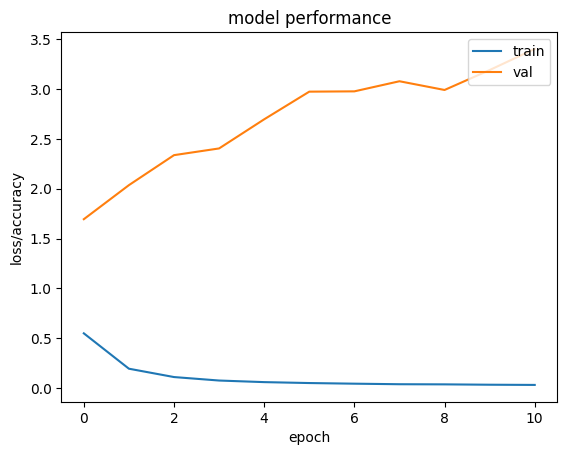

In [ ]:
from matplotlib import pyplot as plt
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model performance')
plt.ylabel('loss/accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# model.save('/content/drive/My Drive/Colab Notebooks/LegalEval/ModelIndLegal_WithOversample_5sent_5hyp.h5')

In [16]:
import keras
model=keras.models.load_model('/content/drive/My Drive/Colab Notebooks/LegalEval/ModelIndLegal_WithOversample_5sent_5hyp.h5')

In [17]:
#prev two sentences and next two sentences

def test1_dataset_creation(doc):
  s1 = np.zeros(768)
  # print(type(s1))
  s2=np.zeros(768)
  s3=np.zeros(768)
  s4=np.zeros(768)

  fl=[]

  dc=[]
  dc.append(s1)
  dc.append(s2)
  dc.append(numpyarray(doc[0]))
  dc.append(numpyarray(doc[1]))
  dc.append(numpyarray(doc[2]))

  
  fl.append(np.stack(dc))
  
  dc=[]
  
  dc.append(s2)
  dc.append(numpyarray(doc[0]))
  
  dc.append(numpyarray(doc[1]))
  dc.append(numpyarray(doc[2]))
  dc.append(numpyarray(doc[3]))
  fl.append(np.stack(dc))
  
  for i in range(2,len(doc)-2):
    dc=[]
    
    dc.append(numpyarray(doc[i-2]))
    dc.append(numpyarray(doc[i-1]))
    dc.append(numpyarray(doc[i]))
    dc.append(numpyarray(doc[i+1]))
    dc.append(numpyarray(doc[i+2]))
    fl.append(np.stack(dc))
    
  # for i in range(len(fl)):
  #   print(fl[i].shape)
  dc=[]
  dc.append(numpyarray(doc[-4]))
  dc.append(numpyarray(doc[-3]))
  dc.append(numpyarray(doc[-2]))
  dc.append(numpyarray(doc[-1]))
  dc.append(s3)
  fl.append(np.stack(dc))
  
  dc=[]
  dc.append(numpyarray(doc[-3]))
  dc.append(numpyarray(doc[-2]))
  dc.append(numpyarray(doc[-1]))
  dc.append(s3)
  dc.append(s4)
  fl.append(np.stack(dc))
  
  fl=np.stack(fl)
  return fl

In [18]:
def predict(doc):
  compPred=[]
  x=test1_dataset_creation(doc)
  y_prob=model.predict(x)
  flat_pred=np.argmax(y_prob,axis=2)
  flat_pred_list= flat_pred.tolist()
  final_preds=[]
  for i in range(len(flat_pred_list)):
    final_preds.append(flat_pred_list[i][2])
  return final_preds

Preds=[]
for i in range(len(CleanedText)):
  Preds.append(predict(CleanedText[i]))
  print(i)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


3/3 [==============================] - 5s 9ms/step
0
5/5 [==============================] - 2s 7ms/step
1
5/5 [==============================] - 0s 5ms/step
2
2/2 [==============================] - 0s 8ms/step
3
3/3 [==============================] - 0s 6ms/step
4
2/2 [==============================] - 0s 14ms/step
5
3/3 [==============================] - 0s 5ms/step
6
4/4 [==============================] - 0s 22ms/step
7
7/7 [==============================] - 0s 6ms/step
8
5/5 [==============================] - 0s 6ms/step
9
3/3 [==============================] - 0s 6ms/step
10
4/4 [==============================] - 0s 5ms/step
11
7/7 [==============================] - 0s 4ms/step
12
5/5 [==============================] - 0s 5ms/step
13
2/2 [==============================] - 0s 9ms/step
14
2/2 [==============================] - 0s 9ms/step
15
4/4 [==============================] - 0s 6ms/step
16
4/4 [==============================] - 0s 6ms/step
17
2/2 [==============================]

In [19]:
num2text_label_dict={0:'analysis',1: 'arg_petitioner',2:'arg_respondent',3:'fac',4: 'issue',
            5:'none',6:'pre_not_relied',7: 'pre_relied',8:'preamble',9:'ratio',10:'rlc',11: 'rpc',12:'sta',13:'pad'}

text2num_label_dict={v:k for k,v in num2text_label_dict.items()}
ActualValLabels=[]
for i in range(len(AllLabels)):
  temp=[]
  for j in range(len(AllLabels[i])):
    temp.append(text2num_label_dict[AllLabels[i][j]])
  ActualValLabels.append(temp)

In [ ]:
#previous 2 sentences and next 2 sentences considered
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

PScore=[]
for i in range(len(ActualValLabels)):
  PScore.append(precision_score(ActualValLabels[i],Preds[i], average='weighted'))
# print(F1Score)
print(sum(PScore)/len(ActualValLabels))

RScore=[]
for i in range(len(ActualValLabels)):
  RScore.append(recall_score(ActualValLabels[i],Preds[i], average='weighted'))
# print(F1Score)
print(sum(RScore)/len(ActualValLabels))

F1Score=[]
for i in range(len(ActualValLabels)):
  F1Score.append(f1_score(ActualValLabels[i],Preds[i], average='weighted'))
# print(F1Score)
print(sum(F1Score)/len(ActualValLabels))

**With $M_{SSO-Mid}$ approach,the scores are as follows:**

Weighted Precision: 0.7807278054078216

Weighted Recall: 0.7382159796008845

Weighted F1-score:0.7345447888373932 

In [22]:
#previous 2 sentences  and 2 next sentences considered
from sklearn.metrics import precision_recall_fscore_support
num2text_label_dict={0:'analysis',1: 'arg_petitioner',2:'arg_respondent',3:'fac',4: 'issue',
            5:'none',6:'pre_not_relied',7: 'pre_relied',8:'preamble',9:'ratio',10:'rlc',11: 'rpc',12:'sta',13:'pad'}

text2num_label_dict={v:k for k,v in num2text_label_dict.items()}
PredValLabels=[]
for i in range(len(Preds)):
  temp=[]
  for j in range(len(Preds[i])):
    temp.append(num2text_label_dict[Preds[i][j]])
  PredValLabels.append(temp)

PredSentwiseLabels=[]
for i in range(len(PredValLabels)):
  for j in range(len(PredValLabels[i])):
    PredSentwiseLabels.append(PredValLabels[i][j])

ActSentwiseLabels=[]
for i in range(len(AllLabels)):
  for j in range(len(AllLabels[i])):
    ActSentwiseLabels.append(AllLabels[i][j])

label_list=['analysis','arg_petitioner','arg_respondent','fac', 'issue','none','pre_not_relied','pre_relied','preamble','ratio','rlc','rpc','sta']
precision_recall_fscore_support(ActSentwiseLabels, PredSentwiseLabels, average=None, labels=label_list)

(array([0.7404943 , 0.24561404, 0.24137931, 0.75684932, 0.73469388,
        0.97468354, 0.25      , 0.42918455, 0.91170431, 0.57142857,
        0.6969697 , 0.93406593, 0.51612903]),
 array([0.79166667, 0.2       , 0.36842105, 0.76206897, 0.72      ,
        0.81052632, 0.08333333, 0.70422535, 0.87401575, 0.34285714,
        0.19827586, 0.93406593, 0.57142857]),
 array([0.76522593, 0.22047244, 0.29166667, 0.75945017, 0.72727273,
        0.88505747, 0.125     , 0.53333333, 0.89246231, 0.42857143,
        0.30872483, 0.93406593, 0.54237288]),
 array([984,  70,  38, 580,  50, 190,  12, 142, 508,  70, 116,  91,  28]))

**Classwise perfromance of $M_{SSO-Mid}$ approach is given in the table below:**

| Classes | Precision | Recall | F1-score |
| ---: | ---: | ---: | ---: |
| analysis | 0.740 | 0.791 | 0.765
| arg_petitioner |0.245 |0.200 | 0.220
| arg_respondent | 0.241|0.368 | 0.291
| fac | 0.756 | 0.762 | 0.759
| issue |0.734 |0.720 |0.727
| none |0.974 | 0.810 |0.885
| pre_not_relied |0.250 |0.083 |0.125
| pre_relied |0.429 | 0.704 | 0.533
| preamble |0.911 | 0.874 |0.892
| ratio |0.571 | 0.342 |0.428
| rlc | 0.696 | 0.198 | 0.308
| rpc | 0.934 | 0.934 |0.934
| sta | 0.516 | 0.571 | 0.542

In [23]:
#considers previous four sentences
def test_dataset_creation(doc):
  s1 = np.zeros(768)
  # print(type(s1))
  s2=np.zeros(768)
  s3=np.zeros(768)
  s4=np.zeros(768)
  fl=[]
  
  dc=[]
  
  dc.append(s1)
  
  dc.append(s2)
  
  dc.append(s3)
  
  dc.append(s4)
  
  dc.append(numpyarray(doc[0]))
  
  fl.append(np.stack(dc))
  
  dc=[]
  
  dc.append(s2)
  
  dc.append(s3)
  
  dc.append(s4)
  
  dc.append(numpyarray(doc[0]))
  
  dc.append(numpyarray(doc[1]))
  
  fl.append(np.stack(dc))
  
  dc=[]
  
  dc.append(s3)
  
  dc.append(s4)
  
  dc.append(numpyarray(doc[0]))
  
  dc.append(numpyarray(doc[1]))
  
  dc.append(numpyarray(doc[2]))
  
  fl.append(np.stack(dc))
  
  dc=[]
  
  dc.append(s4)
  
  dc.append(numpyarray(doc[0]))
  
  dc.append(numpyarray(doc[1]))
  
  dc.append(numpyarray(doc[2]))
  
  dc.append(numpyarray(doc[3]))
  
  fl.append(np.stack(dc))
  

  for i in range(4,len(doc)):
    dc=[]
    
    dc.append(numpyarray(doc[i-4]))
    
    dc.append(numpyarray(doc[i-3]))
    
    dc.append(numpyarray(doc[i-2]))
    
    dc.append(numpyarray(doc[i-1]))
    
    dc.append(numpyarray(doc[i]))
    
    fl.append(np.stack(dc))
    
  # for i in range(len(fl)):
  #   print(fl[i].shape)
  fl=np.stack(fl)
  return fl

In [24]:
def predict(doc):
  compPred=[]
  x=test_dataset_creation(doc)
 
  y_prob=model.predict(x)

  flat_pred=np.argmax(y_prob,axis=2)
  flat_pred_list= flat_pred.tolist()
  final_preds=[]
  for i in range(len(flat_pred_list)):
    final_preds.append(flat_pred_list[i][-1])
   
  return final_preds
Preds=[]
for i in range(len(CleanedText)):
  Preds.append(predict(CleanedText[i]))
  print(i)

3/3 [==============================] - 0s 7ms/step
0
5/5 [==============================] - 0s 7ms/step
1
5/5 [==============================] - 0s 6ms/step
2
2/2 [==============================] - 0s 10ms/step
3
3/3 [==============================] - 0s 7ms/step
4
2/2 [==============================] - 0s 7ms/step
5
3/3 [==============================] - 0s 6ms/step
6
4/4 [==============================] - 0s 8ms/step
7
7/7 [==============================] - 0s 8ms/step
8
5/5 [==============================] - 0s 5ms/step
9
3/3 [==============================] - 0s 8ms/step
10
4/4 [==============================] - 0s 5ms/step
11
7/7 [==============================] - 0s 4ms/step
12
5/5 [==============================] - 0s 6ms/step
13
2/2 [==============================] - 0s 8ms/step
14
2/2 [==============================] - 0s 8ms/step
15
4/4 [==============================] - 0s 8ms/step
16
4/4 [==============================] - 0s 5ms/step
17
2/2 [==============================] 

In [27]:
# #previous 4 sentences considered
# from sklearn.metrics import f1_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import precision_score

# PScore=[]
# for i in range(len(ActualValLabels)):
#   PScore.append(precision_score(ActualValLabels[i],Preds[i], average='weighted'))
# # print(F1Score)
# print(sum(PScore)/len(ActualValLabels))

# RScore=[]
# for i in range(len(ActualValLabels)):
#   RScore.append(recall_score(ActualValLabels[i],Preds[i], average='weighted'))
# # print(F1Score)
# print(sum(RScore)/len(ActualValLabels))

# F1Score=[]
# for i in range(len(ActualValLabels)):
#   F1Score.append(f1_score(ActualValLabels[i],Preds[i], average='weighted'))
# # print(F1Score)
# print(sum(F1Score)/len(ActualValLabels))

**With $M_{SSO-End}$ approach,the scores are as follows:**

Weighted Precision: 0.7566517257545203

Weighted Recall: 0.7204163339127654

Weighted F1-score: 0.7134165421545937

In [26]:
#previous 4 sentences considered
from sklearn.metrics import precision_recall_fscore_support
num2text_label_dict={0:'analysis',1: 'arg_petitioner',2:'arg_respondent',3:'fac',4: 'issue',
            5:'none',6:'pre_not_relied',7: 'pre_relied',8:'preamble',9:'ratio',10:'rlc',11: 'rpc',12:'sta',13:'pad'}

text2num_label_dict={v:k for k,v in num2text_label_dict.items()}
PredValLabels=[]
for i in range(len(Preds)):
  temp=[]
  for j in range(len(Preds[i])):
    temp.append(num2text_label_dict[Preds[i][j]])
  PredValLabels.append(temp)

PredSentwiseLabels=[]
for i in range(len(PredValLabels)):
  for j in range(len(PredValLabels[i])):
    PredSentwiseLabels.append(PredValLabels[i][j])

ActSentwiseLabels=[]
for i in range(len(AllLabels)):
  for j in range(len(AllLabels[i])):
    ActSentwiseLabels.append(AllLabels[i][j])

label_list=['analysis','arg_petitioner','arg_respondent','fac', 'issue','none','pre_not_relied','pre_relied','preamble','ratio','rlc','rpc','sta']
precision_recall_fscore_support(ActSentwiseLabels, PredSentwiseLabels, average=None, labels=label_list)

(array([0.72285714, 0.1627907 , 0.22580645, 0.76262626, 0.67924528,
        0.94011976, 0.        , 0.4248927 , 0.90283401, 0.25      ,
        0.69047619, 0.86746988, 0.51515152]),
 array([0.77134146, 0.1       , 0.36842105, 0.78103448, 0.72      ,
        0.82631579, 0.        , 0.6971831 , 0.87795276, 0.08571429,
        0.25      , 0.79120879, 0.60714286]),
 array([0.74631268, 0.12389381, 0.28      , 0.77172061, 0.69902913,
        0.87955182, 0.        , 0.528     , 0.89021956, 0.12765957,
        0.36708861, 0.82758621, 0.55737705]),
 array([984,  70,  38, 580,  50, 190,  12, 142, 508,  70, 116,  91,  28]))

**Classwise perfromance of $M_{SSO-End}$ approach is given in the table below:**

| Classes | Precision | Recall | F1-score |
| ---: | ---: | ---: | ---: |
| analysis | 0.722 |0.771 |0.746
| arg_petitioner |0.162 |0.100 |0.123
| arg_respondent | 0.225 |0.368|0.28
| fac | 0.762 |0.781|0.771
| issue |0.679|0.720|0.699
| none |0.940 |0.826|0.879
| pre_not_relied | 0.000 |0.000|0.000
| pre_relied |0.424|0.697|0.528
| preamble | 0.902 |0.877|0.890
| ratio | 0.250 |0.085|0.127
| rlc | 0.690|0.250|0.367
| rpc |0.867|0.791|0.827
| sta |0.515 |0.607|0.557